# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [13]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [14]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [15]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

C:\Users\jeann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [16]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [17]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2)
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels)
  def forward(self, z):
    y = F.leaky_relu(self.fc1(z),0.2)
    y = F.leaky_relu(self.fc2(y),0.2)
    return F.tanh(self.fc3(y)).view(-1, self.n_channels, self.n_rows, self.n_cols) 

In [18]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = F.leaky_relu(self.fc1(x.view(-1, self.n_pixels)),0.2)
    y = F.leaky_relu(self.fc2(y),0.2)
    return F.sigmoid(self.fc3(y))


Create generator and discriminator 

In [19]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels).to(device)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels).to(device)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [20]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1-d_gen_data))
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [21]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) 
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.4496	Loss_G: -0.6673	D(x): 0.4578	D(G(z)): 0.4873


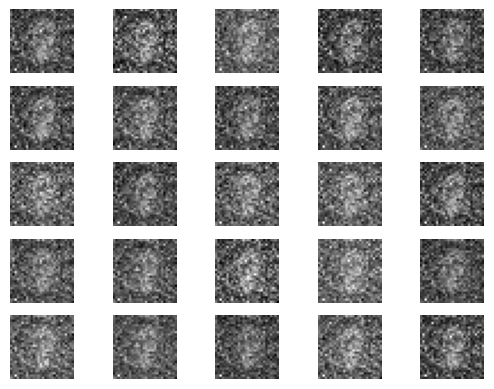

[1/400][0/16] 	Loss_D: 0.9892	Loss_G: -0.7599	D(x): 0.8632	D(G(z)): 0.5686
[2/400][0/16] 	Loss_D: 1.2132	Loss_G: -0.7497	D(x): 0.7338	D(G(z)): 0.5937
[3/400][0/16] 	Loss_D: 1.1803	Loss_G: -0.6291	D(x): 0.6766	D(G(z)): 0.5445
[4/400][0/16] 	Loss_D: 1.3383	Loss_G: -0.6132	D(x): 0.6745	D(G(z)): 0.6082
[5/400][0/16] 	Loss_D: 0.9555	Loss_G: -0.3379	D(x): 0.7613	D(G(z)): 0.4902
[6/400][0/16] 	Loss_D: 0.7528	Loss_G: -0.3335	D(x): 0.7794	D(G(z)): 0.3937
[7/400][0/16] 	Loss_D: 0.6901	Loss_G: -0.1469	D(x): 0.9193	D(G(z)): 0.4020
[8/400][0/16] 	Loss_D: 0.3832	Loss_G: -0.1464	D(x): 0.8583	D(G(z)): 0.2019
[9/400][0/16] 	Loss_D: 0.1501	Loss_G: -0.0797	D(x): 0.9493	D(G(z)): 0.0797
[10/400][0/16] 	Loss_D: 1.2853	Loss_G: -0.6021	D(x): 0.6819	D(G(z)): 0.5122
[11/400][0/16] 	Loss_D: 0.7416	Loss_G: -0.2953	D(x): 0.7813	D(G(z)): 0.3752
[12/400][0/16] 	Loss_D: 1.1508	Loss_G: -0.5533	D(x): 0.5824	D(G(z)): 0.4489
[13/400][0/16] 	Loss_D: 0.9783	Loss_G: -0.3970	D(x): 0.6361	D(G(z)): 0.4027
[14/400][0/16] 	Loss_

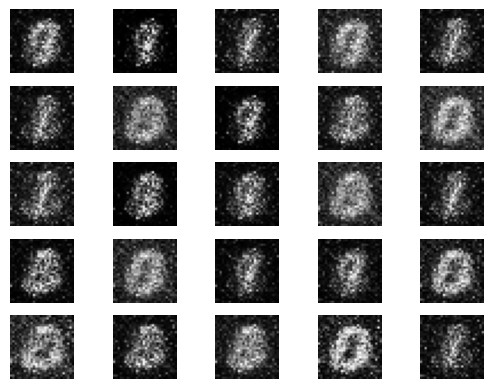

[26/400][0/16] 	Loss_D: 0.7637	Loss_G: -0.2327	D(x): 0.7750	D(G(z)): 0.3838
[27/400][0/16] 	Loss_D: 1.0093	Loss_G: -0.1725	D(x): 0.7552	D(G(z)): 0.4705
[28/400][0/16] 	Loss_D: 0.7261	Loss_G: -0.2953	D(x): 0.7031	D(G(z)): 0.2764
[29/400][0/16] 	Loss_D: 0.9266	Loss_G: -0.2622	D(x): 0.7760	D(G(z)): 0.4743
[30/400][0/16] 	Loss_D: 0.4688	Loss_G: -0.1511	D(x): 0.8407	D(G(z)): 0.2463
[31/400][0/16] 	Loss_D: 0.7807	Loss_G: -0.1052	D(x): 0.8646	D(G(z)): 0.4502
[32/400][0/16] 	Loss_D: 0.7393	Loss_G: -0.3794	D(x): 0.6509	D(G(z)): 0.1891
[33/400][0/16] 	Loss_D: 0.5015	Loss_G: -0.2485	D(x): 0.7619	D(G(z)): 0.1748
[34/400][0/16] 	Loss_D: 1.0448	Loss_G: -0.6268	D(x): 0.5223	D(G(z)): 0.1569
[35/400][0/16] 	Loss_D: 0.6117	Loss_G: -0.1560	D(x): 0.8601	D(G(z)): 0.3345
[36/400][0/16] 	Loss_D: 0.9789	Loss_G: -0.2642	D(x): 0.7426	D(G(z)): 0.4370
[37/400][0/16] 	Loss_D: 0.6313	Loss_G: -0.2489	D(x): 0.7554	D(G(z)): 0.2682
[38/400][0/16] 	Loss_D: 0.5293	Loss_G: -0.2276	D(x): 0.7377	D(G(z)): 0.1750
[39/400][0/1

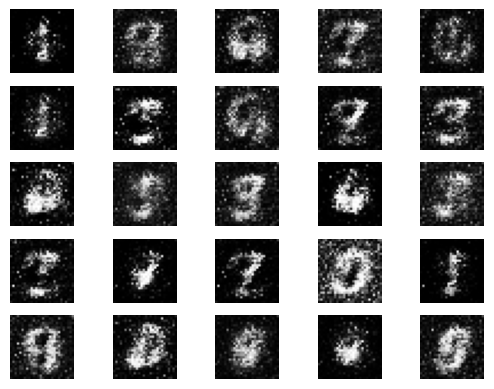

[51/400][0/16] 	Loss_D: 0.7175	Loss_G: -0.3379	D(x): 0.6477	D(G(z)): 0.2127
[52/400][0/16] 	Loss_D: 0.9776	Loss_G: -0.3710	D(x): 0.5693	D(G(z)): 0.2894
[53/400][0/16] 	Loss_D: 0.6010	Loss_G: -0.2946	D(x): 0.7162	D(G(z)): 0.1983
[54/400][0/16] 	Loss_D: 0.8911	Loss_G: -0.4846	D(x): 0.6066	D(G(z)): 0.2468
[55/400][0/16] 	Loss_D: 0.7909	Loss_G: -0.5029	D(x): 0.6598	D(G(z)): 0.2618
[56/400][0/16] 	Loss_D: 0.7164	Loss_G: -0.1055	D(x): 0.8496	D(G(z)): 0.4002
[57/400][0/16] 	Loss_D: 0.9111	Loss_G: -0.2773	D(x): 0.7269	D(G(z)): 0.3954
[58/400][0/16] 	Loss_D: 0.8469	Loss_G: -0.1449	D(x): 0.8822	D(G(z)): 0.4800
[59/400][0/16] 	Loss_D: 1.3445	Loss_G: -0.3803	D(x): 0.6073	D(G(z)): 0.5290
[60/400][0/16] 	Loss_D: 0.5953	Loss_G: -0.1783	D(x): 0.8008	D(G(z)): 0.2936
[61/400][0/16] 	Loss_D: 0.8598	Loss_G: -0.3965	D(x): 0.6462	D(G(z)): 0.2830
[62/400][0/16] 	Loss_D: 1.0400	Loss_G: -0.4205	D(x): 0.6145	D(G(z)): 0.3798
[63/400][0/16] 	Loss_D: 0.9647	Loss_G: -0.4919	D(x): 0.5078	D(G(z)): 0.1217
[64/400][0/1

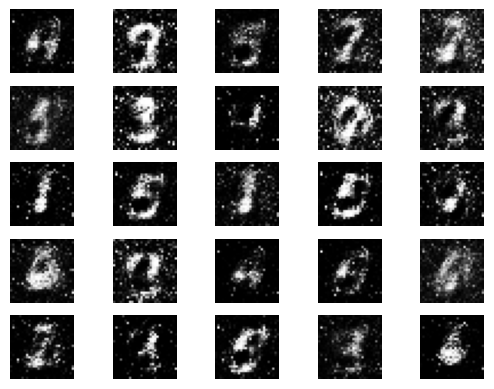

[76/400][0/16] 	Loss_D: 1.2002	Loss_G: -0.0213	D(x): 0.9396	D(G(z)): 0.6369
[77/400][0/16] 	Loss_D: 0.6498	Loss_G: -0.0736	D(x): 0.8690	D(G(z)): 0.3653
[78/400][0/16] 	Loss_D: 0.4782	Loss_G: -0.2434	D(x): 0.8295	D(G(z)): 0.2197
[79/400][0/16] 	Loss_D: 0.4352	Loss_G: -0.1986	D(x): 0.8129	D(G(z)): 0.1607
[80/400][0/16] 	Loss_D: 0.7688	Loss_G: -0.2646	D(x): 0.6003	D(G(z)): 0.0884
[81/400][0/16] 	Loss_D: 0.7804	Loss_G: -0.4655	D(x): 0.5670	D(G(z)): 0.0421
[82/400][0/16] 	Loss_D: 0.4791	Loss_G: -0.1065	D(x): 0.8789	D(G(z)): 0.2725
[83/400][0/16] 	Loss_D: 0.4291	Loss_G: -0.2516	D(x): 0.7852	D(G(z)): 0.1327
[84/400][0/16] 	Loss_D: 0.5711	Loss_G: -0.5249	D(x): 0.6967	D(G(z)): 0.1221
[85/400][0/16] 	Loss_D: 1.2751	Loss_G: -0.3762	D(x): 0.4287	D(G(z)): 0.0331
[86/400][0/16] 	Loss_D: 0.5802	Loss_G: -0.2922	D(x): 0.7751	D(G(z)): 0.2209
[87/400][0/16] 	Loss_D: 0.7291	Loss_G: -0.3197	D(x): 0.6227	D(G(z)): 0.0862
[88/400][0/16] 	Loss_D: 0.5378	Loss_G: -0.0482	D(x): 0.8888	D(G(z)): 0.3023
[89/400][0/1

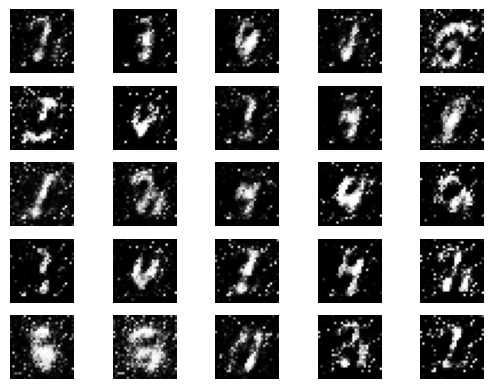

[101/400][0/16] 	Loss_D: 0.5406	Loss_G: -0.1901	D(x): 0.8420	D(G(z)): 0.2503
[102/400][0/16] 	Loss_D: 1.5678	Loss_G: -0.4544	D(x): 0.3459	D(G(z)): 0.0108
[103/400][0/16] 	Loss_D: 0.6987	Loss_G: -0.4319	D(x): 0.7004	D(G(z)): 0.2295
[104/400][0/16] 	Loss_D: 0.6613	Loss_G: -0.3853	D(x): 0.6434	D(G(z)): 0.0788
[105/400][0/16] 	Loss_D: 0.3190	Loss_G: -0.1139	D(x): 0.8560	D(G(z)): 0.1219
[106/400][0/16] 	Loss_D: 0.5609	Loss_G: -0.3021	D(x): 0.7227	D(G(z)): 0.1244
[107/400][0/16] 	Loss_D: 0.4560	Loss_G: -0.2936	D(x): 0.7244	D(G(z)): 0.0668
[108/400][0/16] 	Loss_D: 0.5663	Loss_G: -0.0267	D(x): 0.9377	D(G(z)): 0.3576
[109/400][0/16] 	Loss_D: 0.4425	Loss_G: -0.1522	D(x): 0.8591	D(G(z)): 0.2202
[110/400][0/16] 	Loss_D: 0.3300	Loss_G: -0.1233	D(x): 0.8645	D(G(z)): 0.1455
[111/400][0/16] 	Loss_D: 0.7957	Loss_G: -0.3901	D(x): 0.8399	D(G(z)): 0.3689
[112/400][0/16] 	Loss_D: 0.4225	Loss_G: -0.0718	D(x): 0.8783	D(G(z)): 0.2322
[113/400][0/16] 	Loss_D: 0.4421	Loss_G: -0.0343	D(x): 0.9398	D(G(z)): 0.2779

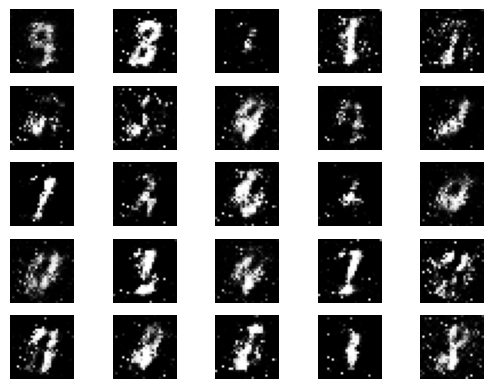

[126/400][0/16] 	Loss_D: 0.3757	Loss_G: -0.1551	D(x): 0.9032	D(G(z)): 0.1903
[127/400][0/16] 	Loss_D: 0.3974	Loss_G: -0.0597	D(x): 0.9527	D(G(z)): 0.2539
[128/400][0/16] 	Loss_D: 0.4116	Loss_G: -0.0053	D(x): 0.9643	D(G(z)): 0.2834
[129/400][0/16] 	Loss_D: 1.8053	Loss_G: -0.0022	D(x): 0.9883	D(G(z)): 0.7789
[130/400][0/16] 	Loss_D: 0.3284	Loss_G: -0.0581	D(x): 0.8300	D(G(z)): 0.0673
[131/400][0/16] 	Loss_D: 0.5448	Loss_G: -0.0268	D(x): 0.9323	D(G(z)): 0.3477
[132/400][0/16] 	Loss_D: 0.5400	Loss_G: -0.0275	D(x): 0.9095	D(G(z)): 0.3121
[133/400][0/16] 	Loss_D: 0.3731	Loss_G: -0.1526	D(x): 0.8434	D(G(z)): 0.1322
[134/400][0/16] 	Loss_D: 0.6759	Loss_G: -0.0088	D(x): 0.9688	D(G(z)): 0.4305
[135/400][0/16] 	Loss_D: 0.2753	Loss_G: -0.0672	D(x): 0.8879	D(G(z)): 0.1103
[136/400][0/16] 	Loss_D: 0.3962	Loss_G: -0.2864	D(x): 0.8365	D(G(z)): 0.1467
[137/400][0/16] 	Loss_D: 0.3026	Loss_G: -0.0363	D(x): 0.9432	D(G(z)): 0.1942
[138/400][0/16] 	Loss_D: 0.9957	Loss_G: -0.0019	D(x): 0.9793	D(G(z)): 0.5804

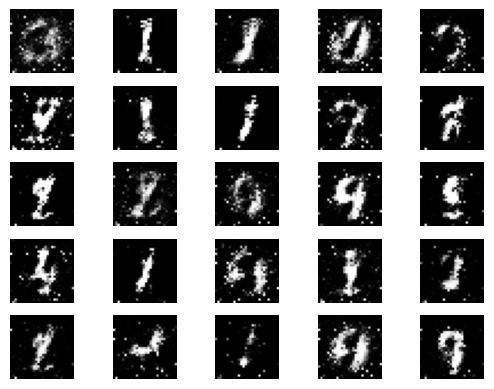

[151/400][0/16] 	Loss_D: 0.3304	Loss_G: -0.1692	D(x): 0.8236	D(G(z)): 0.0866
[152/400][0/16] 	Loss_D: 0.4717	Loss_G: -0.4552	D(x): 0.8288	D(G(z)): 0.1729
[153/400][0/16] 	Loss_D: 0.4445	Loss_G: -0.4375	D(x): 0.7399	D(G(z)): 0.0338
[154/400][0/16] 	Loss_D: 0.3726	Loss_G: -0.2296	D(x): 0.8023	D(G(z)): 0.0800
[155/400][0/16] 	Loss_D: 0.3332	Loss_G: -0.1536	D(x): 0.8257	D(G(z)): 0.0916
[156/400][0/16] 	Loss_D: 1.0081	Loss_G: -0.2341	D(x): 0.5494	D(G(z)): 0.0067
[157/400][0/16] 	Loss_D: 1.1970	Loss_G: -0.0152	D(x): 0.9822	D(G(z)): 0.6206
[158/400][0/16] 	Loss_D: 0.4705	Loss_G: -0.2245	D(x): 0.8889	D(G(z)): 0.2535
[159/400][0/16] 	Loss_D: 0.3965	Loss_G: -0.0941	D(x): 0.7843	D(G(z)): 0.0481
[160/400][0/16] 	Loss_D: 0.7273	Loss_G: -0.4377	D(x): 0.6618	D(G(z)): 0.0211
[161/400][0/16] 	Loss_D: 0.4373	Loss_G: -0.1277	D(x): 0.8618	D(G(z)): 0.1753
[162/400][0/16] 	Loss_D: 0.7777	Loss_G: -0.0014	D(x): 0.9759	D(G(z)): 0.4566
[163/400][0/16] 	Loss_D: 1.1336	Loss_G: -0.3712	D(x): 0.5293	D(G(z)): 0.0495

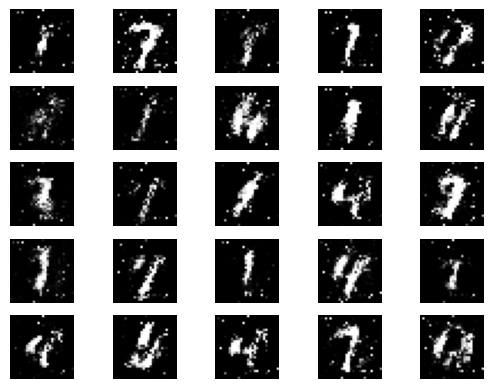

[176/400][0/16] 	Loss_D: 0.2977	Loss_G: -0.0487	D(x): 0.9194	D(G(z)): 0.1616
[177/400][0/16] 	Loss_D: 0.4091	Loss_G: -0.0122	D(x): 0.9436	D(G(z)): 0.2515
[178/400][0/16] 	Loss_D: 0.7810	Loss_G: -0.1640	D(x): 0.6726	D(G(z)): 0.0206
[179/400][0/16] 	Loss_D: 0.3649	Loss_G: -0.0619	D(x): 0.8907	D(G(z)): 0.1677
[180/400][0/16] 	Loss_D: 0.4852	Loss_G: -0.2135	D(x): 0.7738	D(G(z)): 0.1083
[181/400][0/16] 	Loss_D: 0.2752	Loss_G: -0.1796	D(x): 0.8893	D(G(z)): 0.0910
[182/400][0/16] 	Loss_D: 0.3939	Loss_G: -0.0744	D(x): 0.9266	D(G(z)): 0.2254
[183/400][0/16] 	Loss_D: 0.5275	Loss_G: -0.0953	D(x): 0.8354	D(G(z)): 0.2142
[184/400][0/16] 	Loss_D: 0.4938	Loss_G: -0.1114	D(x): 0.8944	D(G(z)): 0.2592
[185/400][0/16] 	Loss_D: 0.3609	Loss_G: -0.0866	D(x): 0.8953	D(G(z)): 0.1776
[186/400][0/16] 	Loss_D: 0.2695	Loss_G: -0.1457	D(x): 0.8792	D(G(z)): 0.1057
[187/400][0/16] 	Loss_D: 0.3999	Loss_G: -0.1911	D(x): 0.8603	D(G(z)): 0.1641
[188/400][0/16] 	Loss_D: 1.0498	Loss_G: -0.4913	D(x): 0.5216	D(G(z)): 0.0153

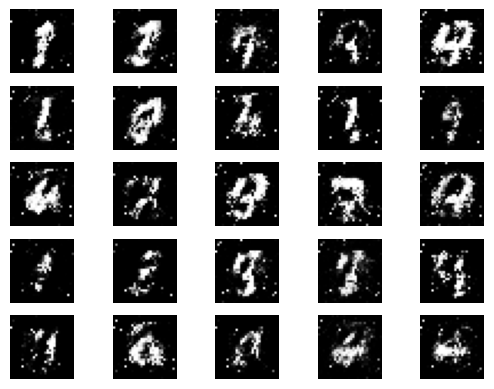

[201/400][0/16] 	Loss_D: 0.4945	Loss_G: -0.0857	D(x): 0.8688	D(G(z)): 0.2159
[202/400][0/16] 	Loss_D: 0.3175	Loss_G: -0.1175	D(x): 0.8918	D(G(z)): 0.1558
[203/400][0/16] 	Loss_D: 0.3565	Loss_G: -0.1442	D(x): 0.8576	D(G(z)): 0.1477
[204/400][0/16] 	Loss_D: 0.9959	Loss_G: -0.4479	D(x): 0.5524	D(G(z)): 0.0114
[205/400][0/16] 	Loss_D: 0.2979	Loss_G: -0.0747	D(x): 0.8847	D(G(z)): 0.1228
[206/400][0/16] 	Loss_D: 0.4514	Loss_G: -0.0298	D(x): 0.9526	D(G(z)): 0.2672
[207/400][0/16] 	Loss_D: 0.4568	Loss_G: -0.4167	D(x): 0.7737	D(G(z)): 0.0466
[208/400][0/16] 	Loss_D: 0.6028	Loss_G: -0.2015	D(x): 0.6925	D(G(z)): 0.0432
[209/400][0/16] 	Loss_D: 0.3020	Loss_G: -0.0731	D(x): 0.8984	D(G(z)): 0.1484
[210/400][0/16] 	Loss_D: 0.2472	Loss_G: -0.0536	D(x): 0.9231	D(G(z)): 0.1317
[211/400][0/16] 	Loss_D: 0.3161	Loss_G: -0.0342	D(x): 0.9462	D(G(z)): 0.1983
[212/400][0/16] 	Loss_D: 0.2742	Loss_G: -0.0744	D(x): 0.8413	D(G(z)): 0.0461
[213/400][0/16] 	Loss_D: 0.4547	Loss_G: -0.0545	D(x): 0.9527	D(G(z)): 0.2898

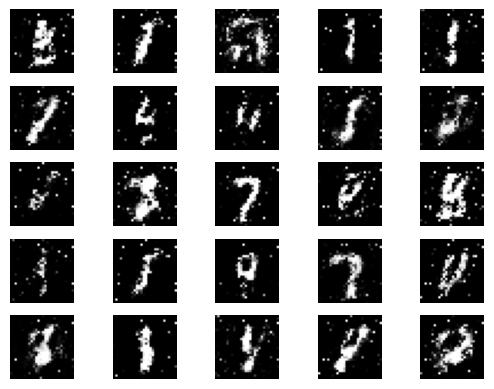

[226/400][0/16] 	Loss_D: 0.2114	Loss_G: -0.0410	D(x): 0.9424	D(G(z)): 0.1288
[227/400][0/16] 	Loss_D: 0.4237	Loss_G: -0.0524	D(x): 0.9397	D(G(z)): 0.2546
[228/400][0/16] 	Loss_D: 0.4693	Loss_G: -0.1762	D(x): 0.9174	D(G(z)): 0.2841
[229/400][0/16] 	Loss_D: 0.4747	Loss_G: -0.0559	D(x): 0.9046	D(G(z)): 0.2632
[230/400][0/16] 	Loss_D: 0.2513	Loss_G: -0.1103	D(x): 0.8932	D(G(z)): 0.1042
[231/400][0/16] 	Loss_D: 0.2831	Loss_G: -0.1103	D(x): 0.9134	D(G(z)): 0.1375
[232/400][0/16] 	Loss_D: 0.2842	Loss_G: -0.1249	D(x): 0.8970	D(G(z)): 0.1130
[233/400][0/16] 	Loss_D: 0.1913	Loss_G: -0.0702	D(x): 0.8940	D(G(z)): 0.0518
[234/400][0/16] 	Loss_D: 0.6007	Loss_G: -0.3792	D(x): 0.8375	D(G(z)): 0.2528
[235/400][0/16] 	Loss_D: 0.8925	Loss_G: -0.0319	D(x): 0.9482	D(G(z)): 0.4671
[236/400][0/16] 	Loss_D: 0.3352	Loss_G: -0.0483	D(x): 0.9506	D(G(z)): 0.2205
[237/400][0/16] 	Loss_D: 0.6985	Loss_G: -0.4416	D(x): 0.6541	D(G(z)): 0.0111
[238/400][0/16] 	Loss_D: 1.1556	Loss_G: -0.4606	D(x): 0.5225	D(G(z)): 0.0199

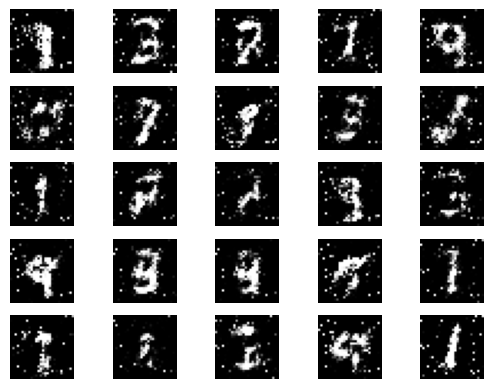

[251/400][0/16] 	Loss_D: 0.3014	Loss_G: -0.0862	D(x): 0.8395	D(G(z)): 0.0599
[252/400][0/16] 	Loss_D: 0.4646	Loss_G: -0.3036	D(x): 0.8018	D(G(z)): 0.1333
[253/400][0/16] 	Loss_D: 0.7262	Loss_G: -0.0289	D(x): 0.9414	D(G(z)): 0.3815
[254/400][0/16] 	Loss_D: 0.3390	Loss_G: -0.1243	D(x): 0.8538	D(G(z)): 0.1151
[255/400][0/16] 	Loss_D: 0.6822	Loss_G: -0.0163	D(x): 0.9826	D(G(z)): 0.3830
[256/400][0/16] 	Loss_D: 0.3834	Loss_G: -0.1700	D(x): 0.8284	D(G(z)): 0.1150
[257/400][0/16] 	Loss_D: 0.3605	Loss_G: -0.1167	D(x): 0.8729	D(G(z)): 0.1483
[258/400][0/16] 	Loss_D: 1.1957	Loss_G: -0.1144	D(x): 0.9607	D(G(z)): 0.5326
[259/400][0/16] 	Loss_D: 0.3125	Loss_G: -0.0484	D(x): 0.9214	D(G(z)): 0.1824
[260/400][0/16] 	Loss_D: 0.5372	Loss_G: -0.2152	D(x): 0.6988	D(G(z)): 0.0313
[261/400][0/16] 	Loss_D: 0.5486	Loss_G: -0.0554	D(x): 0.8676	D(G(z)): 0.2552
[262/400][0/16] 	Loss_D: 0.8557	Loss_G: -0.0115	D(x): 0.9643	D(G(z)): 0.4798
[263/400][0/16] 	Loss_D: 0.6825	Loss_G: -0.4041	D(x): 0.6367	D(G(z)): 0.0236

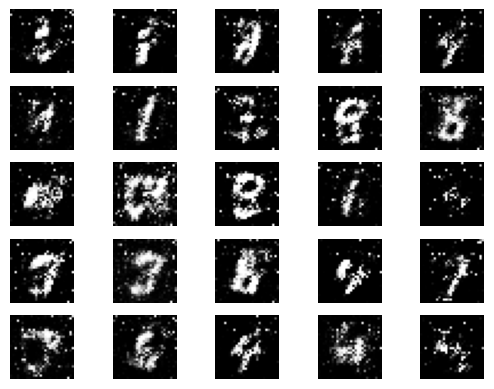

[276/400][0/16] 	Loss_D: 0.4215	Loss_G: -0.0816	D(x): 0.9334	D(G(z)): 0.2639
[277/400][0/16] 	Loss_D: 0.2131	Loss_G: -0.0684	D(x): 0.9037	D(G(z)): 0.0806
[278/400][0/16] 	Loss_D: 1.8713	Loss_G: -0.0029	D(x): 0.9872	D(G(z)): 0.7694
[279/400][0/16] 	Loss_D: 0.4662	Loss_G: -0.0659	D(x): 0.8431	D(G(z)): 0.1969
[280/400][0/16] 	Loss_D: 0.4289	Loss_G: -0.2035	D(x): 0.8142	D(G(z)): 0.1396
[281/400][0/16] 	Loss_D: 0.3814	Loss_G: -0.0931	D(x): 0.8983	D(G(z)): 0.1911
[282/400][0/16] 	Loss_D: 0.8852	Loss_G: -0.4591	D(x): 0.5551	D(G(z)): 0.0256
[283/400][0/16] 	Loss_D: 0.5242	Loss_G: -0.0362	D(x): 0.9369	D(G(z)): 0.3150
[284/400][0/16] 	Loss_D: 0.4162	Loss_G: -0.1111	D(x): 0.8692	D(G(z)): 0.1820
[285/400][0/16] 	Loss_D: 0.5828	Loss_G: -0.4157	D(x): 0.7395	D(G(z)): 0.1375
[286/400][0/16] 	Loss_D: 0.6044	Loss_G: -0.0459	D(x): 0.9143	D(G(z)): 0.3478
[287/400][0/16] 	Loss_D: 0.3387	Loss_G: -0.0726	D(x): 0.8830	D(G(z)): 0.1562
[288/400][0/16] 	Loss_D: 0.9932	Loss_G: -0.0929	D(x): 0.9640	D(G(z)): 0.5148

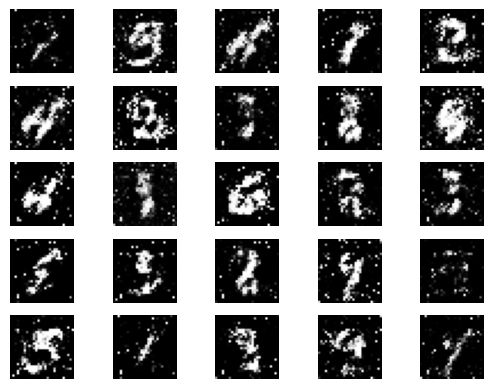

[301/400][0/16] 	Loss_D: 0.3722	Loss_G: -0.3825	D(x): 0.7780	D(G(z)): 0.0630
[302/400][0/16] 	Loss_D: 0.2303	Loss_G: -0.1151	D(x): 0.8817	D(G(z)): 0.0725
[303/400][0/16] 	Loss_D: 0.9663	Loss_G: -1.2658	D(x): 0.5396	D(G(z)): 0.0218
[304/400][0/16] 	Loss_D: 0.3755	Loss_G: -0.1626	D(x): 0.7890	D(G(z)): 0.0750
[305/400][0/16] 	Loss_D: 0.5113	Loss_G: -0.4454	D(x): 0.7255	D(G(z)): 0.0920
[306/400][0/16] 	Loss_D: 0.3716	Loss_G: -0.0914	D(x): 0.8945	D(G(z)): 0.1948
[307/400][0/16] 	Loss_D: 0.6577	Loss_G: -0.0528	D(x): 0.9331	D(G(z)): 0.3494
[308/400][0/16] 	Loss_D: 0.7172	Loss_G: -0.2223	D(x): 0.7749	D(G(z)): 0.2408
[309/400][0/16] 	Loss_D: 0.6643	Loss_G: -0.0603	D(x): 0.9398	D(G(z)): 0.3914
[310/400][0/16] 	Loss_D: 0.4389	Loss_G: -0.1644	D(x): 0.8680	D(G(z)): 0.2180
[311/400][0/16] 	Loss_D: 0.4280	Loss_G: -0.0620	D(x): 0.8981	D(G(z)): 0.2250
[312/400][0/16] 	Loss_D: 2.1530	Loss_G: -0.0089	D(x): 0.9802	D(G(z)): 0.8223
[313/400][0/16] 	Loss_D: 0.4748	Loss_G: -0.2408	D(x): 0.7646	D(G(z)): 0.1129

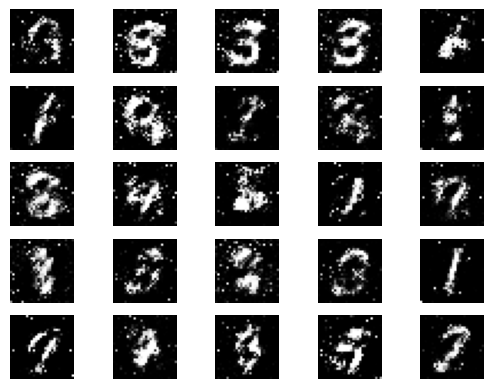

[326/400][0/16] 	Loss_D: 1.2187	Loss_G: -0.5474	D(x): 0.4505	D(G(z)): 0.0866
[327/400][0/16] 	Loss_D: 0.6665	Loss_G: -0.1964	D(x): 0.7595	D(G(z)): 0.2508
[328/400][0/16] 	Loss_D: 0.9541	Loss_G: -0.0805	D(x): 0.9316	D(G(z)): 0.5143
[329/400][0/16] 	Loss_D: 0.6930	Loss_G: -0.2707	D(x): 0.7273	D(G(z)): 0.2166
[330/400][0/16] 	Loss_D: 0.9576	Loss_G: -0.0377	D(x): 0.9250	D(G(z)): 0.4757
[331/400][0/16] 	Loss_D: 0.6254	Loss_G: -0.1050	D(x): 0.8727	D(G(z)): 0.3344
[332/400][0/16] 	Loss_D: 0.4385	Loss_G: -0.1270	D(x): 0.9212	D(G(z)): 0.2512
[333/400][0/16] 	Loss_D: 1.2507	Loss_G: -0.0066	D(x): 0.9595	D(G(z)): 0.6291
[334/400][0/16] 	Loss_D: 0.6533	Loss_G: -0.1799	D(x): 0.7870	D(G(z)): 0.2343
[335/400][0/16] 	Loss_D: 0.4135	Loss_G: -0.0895	D(x): 0.8735	D(G(z)): 0.2045
[336/400][0/16] 	Loss_D: 0.4723	Loss_G: -0.1626	D(x): 0.8686	D(G(z)): 0.2325
[337/400][0/16] 	Loss_D: 0.5019	Loss_G: -0.1014	D(x): 0.8529	D(G(z)): 0.2565
[338/400][0/16] 	Loss_D: 0.6151	Loss_G: -0.3620	D(x): 0.6849	D(G(z)): 0.1060

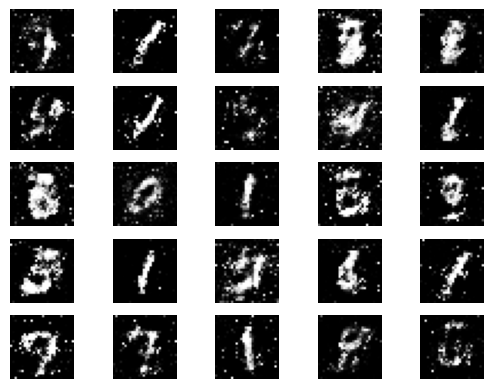

[351/400][0/16] 	Loss_D: 0.8266	Loss_G: -0.3498	D(x): 0.6744	D(G(z)): 0.1983
[352/400][0/16] 	Loss_D: 0.6162	Loss_G: -0.0958	D(x): 0.8553	D(G(z)): 0.3126
[353/400][0/16] 	Loss_D: 0.5038	Loss_G: -0.1141	D(x): 0.7892	D(G(z)): 0.1843
[354/400][0/16] 	Loss_D: 0.5102	Loss_G: -0.3307	D(x): 0.7345	D(G(z)): 0.0973
[355/400][0/16] 	Loss_D: 0.4664	Loss_G: -0.2746	D(x): 0.7787	D(G(z)): 0.1366
[356/400][0/16] 	Loss_D: 1.0829	Loss_G: -0.8134	D(x): 0.4889	D(G(z)): 0.0446
[357/400][0/16] 	Loss_D: 0.6277	Loss_G: -0.4970	D(x): 0.6610	D(G(z)): 0.0929
[358/400][0/16] 	Loss_D: 0.5184	Loss_G: -0.2352	D(x): 0.8207	D(G(z)): 0.2269
[359/400][0/16] 	Loss_D: 0.6309	Loss_G: -0.0626	D(x): 0.9241	D(G(z)): 0.3882
[360/400][0/16] 	Loss_D: 0.5983	Loss_G: -0.0778	D(x): 0.8829	D(G(z)): 0.3215
[361/400][0/16] 	Loss_D: 0.5948	Loss_G: -0.1634	D(x): 0.8255	D(G(z)): 0.2852
[362/400][0/16] 	Loss_D: 0.6190	Loss_G: -0.3013	D(x): 0.6611	D(G(z)): 0.0836
[363/400][0/16] 	Loss_D: 0.5327	Loss_G: -0.1353	D(x): 0.8692	D(G(z)): 0.2737

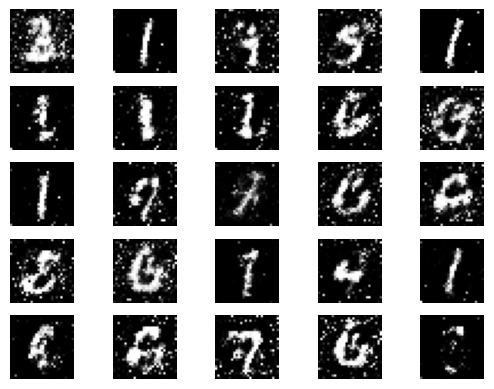

[376/400][0/16] 	Loss_D: 0.7705	Loss_G: -0.6505	D(x): 0.5747	D(G(z)): 0.0856
[377/400][0/16] 	Loss_D: 0.6287	Loss_G: -0.1750	D(x): 0.8264	D(G(z)): 0.2898
[378/400][0/16] 	Loss_D: 0.4800	Loss_G: -0.1832	D(x): 0.7472	D(G(z)): 0.0904
[379/400][0/16] 	Loss_D: 0.6146	Loss_G: -0.0772	D(x): 0.8776	D(G(z)): 0.3491
[380/400][0/16] 	Loss_D: 0.4871	Loss_G: -0.1921	D(x): 0.7515	D(G(z)): 0.1092
[381/400][0/16] 	Loss_D: 0.6789	Loss_G: -0.2091	D(x): 0.7296	D(G(z)): 0.1994
[382/400][0/16] 	Loss_D: 0.6075	Loss_G: -0.1515	D(x): 0.8755	D(G(z)): 0.3368
[383/400][0/16] 	Loss_D: 0.6338	Loss_G: -0.5220	D(x): 0.6787	D(G(z)): 0.1211
[384/400][0/16] 	Loss_D: 0.5407	Loss_G: -0.1556	D(x): 0.9010	D(G(z)): 0.3031
[385/400][0/16] 	Loss_D: 0.4718	Loss_G: -0.3351	D(x): 0.7559	D(G(z)): 0.1293
[386/400][0/16] 	Loss_D: 1.1146	Loss_G: -0.0201	D(x): 0.9356	D(G(z)): 0.5850
[387/400][0/16] 	Loss_D: 0.8492	Loss_G: -0.4085	D(x): 0.5583	D(G(z)): 0.0511
[388/400][0/16] 	Loss_D: 0.6024	Loss_G: -0.2929	D(x): 0.6825	D(G(z)): 0.0729

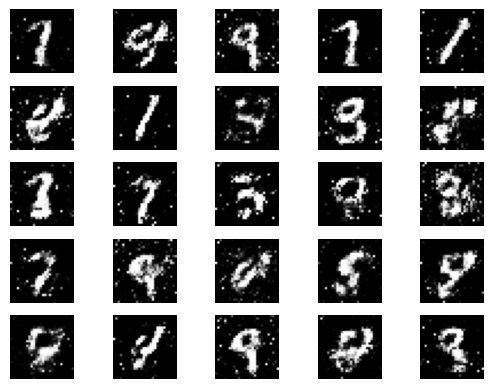

In [22]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device)
      true_labels = torch.ones(true_imgs.shape[0],1).to(device)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs)
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels)
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(batch_size, z_dim, dtype=torch.float, device=device) 
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)
      fake_labels = torch.zeros(fake_imgs.shape[0],1).to(device)
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach())
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs)
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake)
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

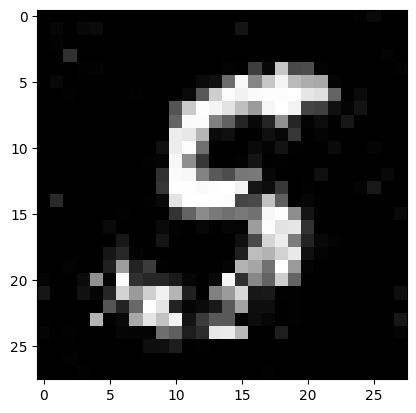

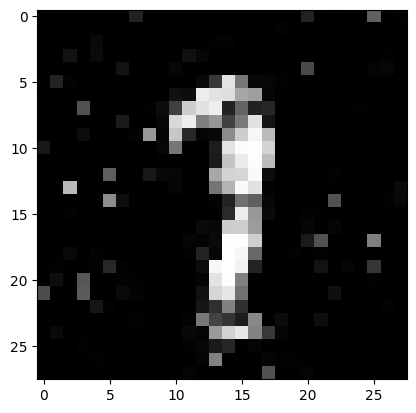

In [41]:
# first image
random_seed = 680 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.randn(1,1, z_dim, dtype=torch.float, device=device)
x_0 = gen_model(z_0)

random_seed = 90 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.randn(1,1, z_dim, dtype=torch.float, device=device)
x_1 = gen_model(z_1) 

# display images
# FILL IN HERE
    
plt.imshow(x_0.cpu().detach().numpy().reshape(n_rows,n_cols), cmap='gray')
plt.show()

plt.imshow(x_1.cpu().detach().numpy().reshape(n_rows,n_cols), cmap='gray')
plt.show()


Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [43]:
n_interpolation = 20

# FILL IN HERE
t = np.linspace(0,1,num=n_interpolation)
z_tab = torch.lerp(z_0, z_1,torch.tensor(t, dtype=torch.float32).to(device).view(-1, 1))

interpolated_imgs = gen_model(z_tab)

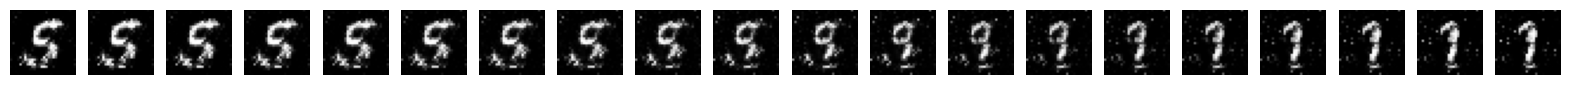

In [47]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].imshow(interpolated_imgs[i, 0, :,:].cpu().detach().numpy(),cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__

Les images générées au milieu de l'interpolation ne ressemblent pas à des chiffres. Cela est dû au fait que l'espace latent n'est pas linéaire. Il faudrait tenter une autre forme d'interpolation.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [63]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

# FILL IN HERE
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    torch.nn.Conv2d(n_h_0, n_h_1, kernel_size, padding=0, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(n_h_1, n_h_2, kernel_size, padding=0, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(pool_size),
    torch.nn.Flatten(),
    torch.nn.Linear(12*12*nb_filters, nb_classes)).to(device)
    

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [66]:
# training the classifier

# FILL IN HERE
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs.to(device))
    # apply loss function
    loss=criterion(predict,labels.to(device))
    acc = get_accuracy(torch.argmax(predict,dim=1),labels.to(device))
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0086 Accuracy:0.9000
Epoch:1 Train Loss:0.0023 Accuracy:0.9750
Epoch:2 Train Loss:0.0071 Accuracy:0.9000
Epoch:3 Train Loss:0.0015 Accuracy:0.9750
Epoch:4 Train Loss:0.0006 Accuracy:1.0000
Epoch:5 Train Loss:0.0002 Accuracy:1.0000
Epoch:6 Train Loss:0.0001 Accuracy:1.0000
Epoch:7 Train Loss:0.0000 Accuracy:1.0000
Epoch:8 Train Loss:0.0000 Accuracy:1.0000
Epoch:9 Train Loss:0.0000 Accuracy:1.0000
Epoch:10 Train Loss:0.0000 Accuracy:1.0000
Epoch:11 Train Loss:0.0000 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [71]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.max(nn.Softmax(dim=1)(classification_model(imgs_in)), dim=1)[1] # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [72]:
z_classes = predict_mnist_class(interpolated_imgs,mnist_classification_model) 
print(z_classes)

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 3, 3, 3, 3, 3, 1, 1, 1],
       device='cuda:0')


__Answer__

L'espace latent traverse des régions de classes autres que celles de $z_0$ et $z_1$ (9 et 3).

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [73]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(nn.Softmax(dim=1)(classification_model(imgs_in)), dim=1).values # FILL IN HERE
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [74]:
z_confidence = predict_mnist_confidence(interpolated_imgs,mnist_classification_model)
print(z_confidence)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 0.9962, 0.9364,
        0.5403, 0.8154, 0.7200, 0.6932, 0.9215, 0.9383, 0.8542, 0.6482, 0.4960,
        0.7034, 0.8301], device='cuda:0', grad_fn=<MaxBackward0>)


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

La valeur change beaucoup pendant l'interpolation. La navigation passe par des zones où la classification n'est pas confiante. Cela correspond bien aux images où une autre classe que celle de $z_0$ et $z_1$ est prédite.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE